# FASHION-MNIST dataset  -- Classification using neural network with fully connected layers

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
# import torchsummary

import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading, Preprocessing and Exploration

### Dataset Loading and Splitting

In [3]:
import os
import urllib.request
from sh import gunzip
import numpy as np
from sklearn.model_selection import train_test_split
from mlxtend.data import loadlocal_mnist

class FashionMnistLoader:
    
    dir_name = "data/fashion"
    url_train_imgs = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
    url_train_labels = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
    url_test_imgs = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
    url_test_labels = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"
    
    def __init__(self):
        self.train_imgs_fn = None
        self.train_labels_fn = None
        self.test_imgs_fn = None
        self.test_labels_fn = None
        
    def get_data(self, url):
        gz_file_name = url.split("/")[-1]
        gz_file_path = os.path.join(self.dir_name, gz_file_name)  
        file_name = gz_file_name.split(".")[0]
        file_path = os.path.join(self.dir_name, file_name)
        os.makedirs(self.dir_name, exist_ok=True)
        if not os.path.exists(file_path):
            urllib.request.urlretrieve(url, gz_file_path) 
            gunzip(gz_file_path)  
        return file_path
        
    def get_all_data(self):
        self.train_imgs_fn = self.get_data(self.url_train_imgs)
        self.train_labels_fn = self.get_data(self.url_train_labels)
        self.test_imgs_fn = self.get_data(self.url_test_imgs)
        self.test_labels_fn = self.get_data(self.url_test_labels)
        return self
    
    def load_train(self):
        X, y = loadlocal_mnist(
            images_path=self.train_imgs_fn, 
            labels_path=self.train_labels_fn)
        return X, y
    
    def load_test(self):
        X, y = loadlocal_mnist(
            images_path=self.test_imgs_fn, 
            labels_path=self.test_labels_fn)
        return X, y
    
    def _split(self, X, y, test_size):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=666)
        return X_train, X_test, y_train, y_test
            
    def train_split(self, test_size):
        X, y = self.load_train()
        X_train, X_test, y_train, y_test = self._split(X, y, test_size)
        return X_train, X_test, y_train, y_test

    def standard_split(self):
        X_train, y_train = self.load_train()
        X_test, y_test = self.load_test()
        return X_train, X_test, y_train, y_test

    

In [4]:
data_loader = FashionMnistLoader().get_all_data()

X_train_dev, X_test, y_train_dev, y_test = data_loader.standard_split()
X_train_dev.shape, X_test.shape, len(y_train_dev), len(y_test)

((60000, 784), (10000, 784), 60000, 10000)

In [5]:
X_train, X_dev, y_train, y_dev = data_loader.train_split(1/6)
X_train.shape, X_dev.shape, len(y_train), len(y_dev)

((50000, 784), (10000, 784), 50000, 10000)

``` torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods:

- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get ith sample

Our dataset will as well apply a processing to each sample whenever we get an item by id, this is done by applying a ```transforms```. 

Let’s say we want to normalize the values of each sample and pass it to tensors. ```torchvision.transforms.Compose``` is a simple callable class which allows us to concatenate more than one transform. 

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize([0], [1])])

class FashionMnist(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.data = (torch.from_numpy(X).float()/255).reshape(-1, 1, 28, 28).squeeze()
        self.target = torch.from_numpy(y).long()
        self.transform = transform
        
    def __len__(self):
        return len(self.target)
        
    def __getitem__(self, index):
        img, tar = self.data[index], self.target[index]
        if self.transform:
            img = self.transform(img)
        return img, tar
    
train_dataset = FashionMnist(X_train, y_train, transform=transform)
dev_dataset = FashionMnist(X_dev, y_dev, transform=transform)

In [7]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(classes)

```torch.utils.data.DataLoader``` is an iterator which provides all these features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

Parameters used below should be clear. One parameter of interest is ```collate_fn```. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [8]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [9]:
dataiter = iter(train_loader)
images_pt, labels = dataiter.next()

### Let's look a bit at data

In [10]:
images = images_pt.numpy()

In [11]:
images[0].max()

1.0

In [12]:
images[0].min()

0.0

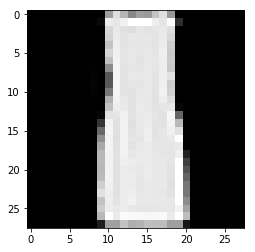

In [14]:
plt.imshow(np.squeeze(images[0]), cmap='gray')
plt.show()

In [15]:
images.shape

(16, 1, 28, 28)

#### What is that

(`batch size`, `number of channels`, `y`, `x`)

So we will have to __flatten__ it!!!

In [16]:
images_pt.reshape(images_pt.size(0), -1).shape

torch.Size([16, 784])

Let's look a bit more on images.

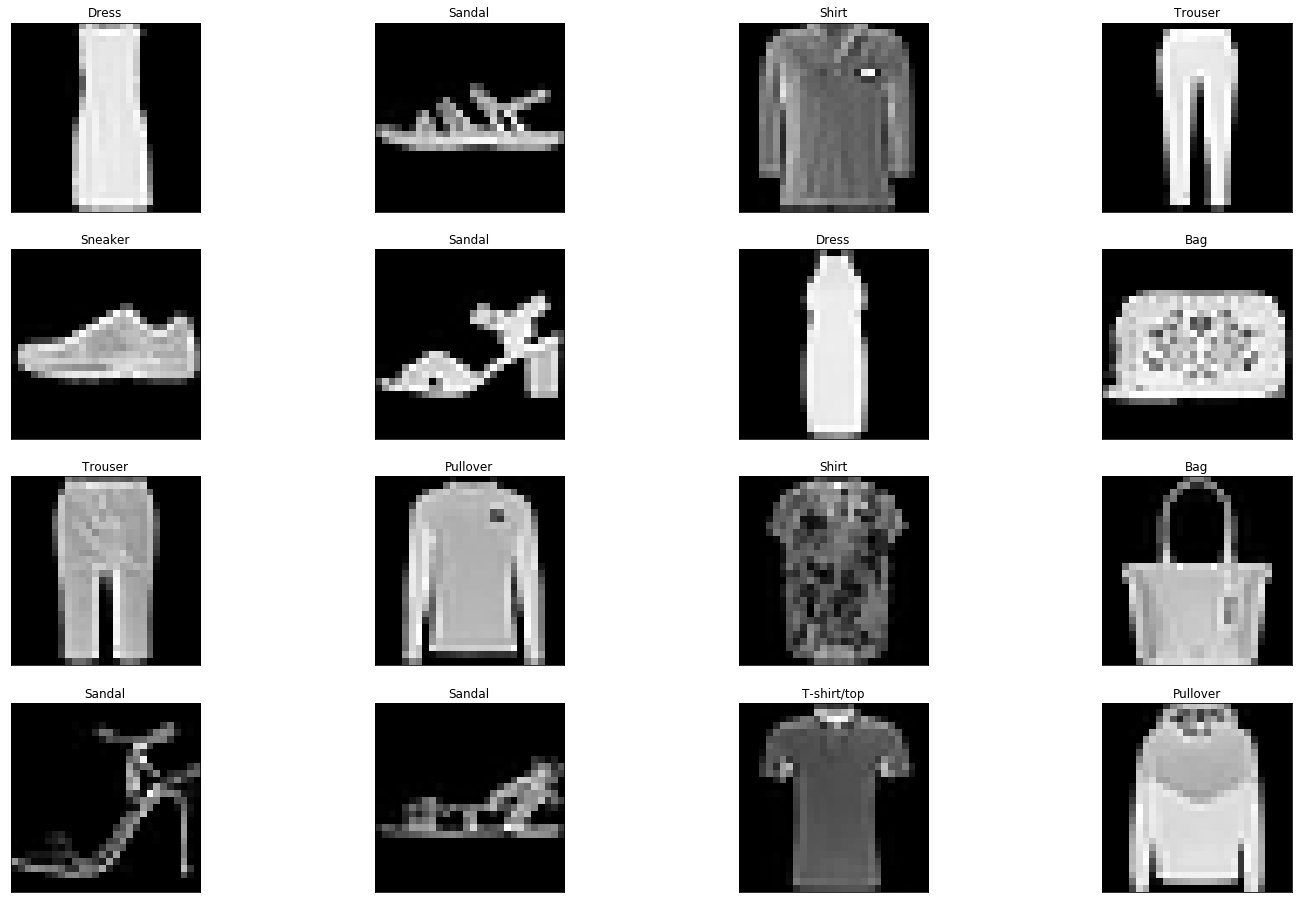

In [17]:
fig = plt.figure(figsize=(25, 16))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])
fig

In [18]:
idx = np.random.choice(batch_size)
img = np.squeeze(images[idx])

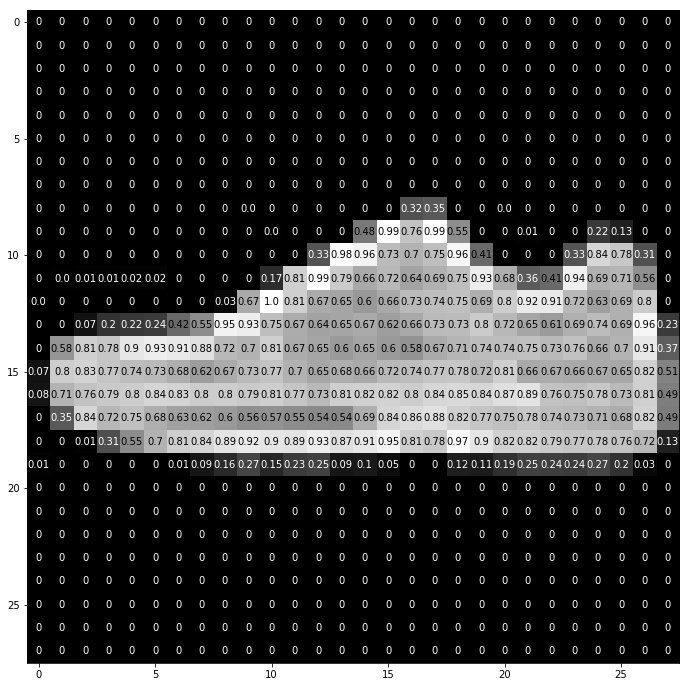

In [19]:
# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
fig

## Let's define Neural Network with pytorch

In [10]:
from torch import nn
from torch import optim
import torch.nn.functional as F

### Reminder of Logistic Regression
Let's remember Logistic Regression. Recall that output is a probablity and can be written as. 

$$y = f(w_1 x_1 + w_2 x_2 + w_3 x_3 + b)$$

where $f$ here is the sigmoid function given by formula:

$$f(x) = \frac{1}{1 + \exp(-x)}.$$

Then we can represent it as

![Simple Neuron 1](docs/pngs/logreg1.png)

We call $f$ by __activation function__ since it relates to __perceptron__, a mathematical model of a neuron. We can think about inputs as signals that a perceptron receives. Then preceptron pust them all together and $f$ activates that is take a decision if the sample belongs to the traget class or not. 

Often we simplify this picture by ploting is as

![Simple Neuron 2](docs/pngs/logreg2.png)

### Some activations

#### Sigmoid

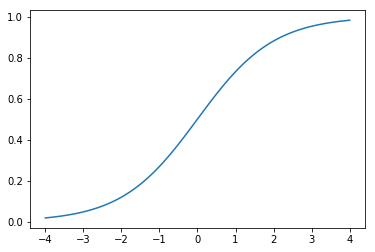

In [22]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


x = np.linspace(-4, 4, 100)
plt.plot(x, sigmoid(x))
plt.show()

#### Identity

We can see Linear Regression as perceptron with identity activation. That is

$$f(x) = x.$$

#### Hyperbolic tangent

This one is very popular when we need an oputput that is a number between $(-1, 1)$.

$$f(x) = \frac{2}{1 + \exp(-2x)} - 1$$

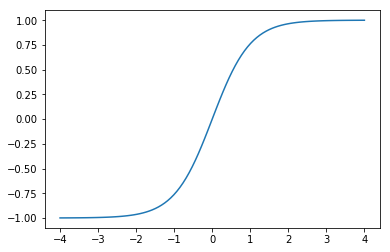

In [23]:
def tanh(x):
    return 2/(1 + np.exp(-2* x)) - 1

plt.plot(x, tanh(x))
plt.show()

#### ReLU

$$f(x) = \left\{ \begin{array}{lll} 0 & \textrm{for} & x < 0\\ x & \textrm{for} & x \geq 0 \end{array}\right.$$

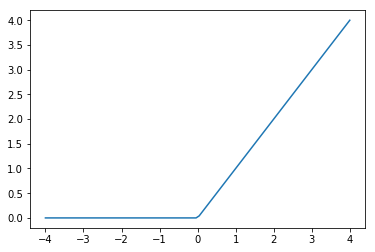

In [24]:
def relu(x):
    return (x >= 0) * x

plt.plot(x, relu(x))
plt.show()

### Neural Network

The neural network is a structure that joins together perceptrons. Here we can see an example of it.

![Simple Neuron 2](docs/pngs/nn.png)


### Defining a Neural Network
Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing ```nn.Module``` and defining a ```forward``` which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In this example we implement our two-layer network as a custom Module subclass:

In [11]:
input_dim = 28 * 28

class LinearNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
    def compute_parameter_number(self):
        num_param = sum(val.numel() for _,val in self.named_parameters())
        return num_param
    
    
model = LinearNN()

The learnable parameters of a model are returned by ```model.parameters()``` and ```model.named_parameters()```

In [12]:
list(model.parameters())  

[Parameter containing:
 tensor([[-0.0261, -0.0326, -0.0120,  ..., -0.0293,  0.0228, -0.0174],
         [ 0.0180,  0.0297, -0.0349,  ..., -0.0344, -0.0097,  0.0213],
         [ 0.0027,  0.0050,  0.0136,  ...,  0.0076, -0.0343,  0.0015],
         ...,
         [ 0.0066,  0.0044,  0.0318,  ...,  0.0074,  0.0244,  0.0103],
         [-0.0310,  0.0103,  0.0159,  ..., -0.0079, -0.0107,  0.0140],
         [ 0.0151, -0.0153, -0.0206,  ...,  0.0010, -0.0148, -0.0258]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0171,  0.0331,  0.0266, -0.0074,  0.0219, -0.0083, -0.0202,  0.0023,
         -0.0330, -0.0339,  0.0068, -0.0073,  0.0087, -0.0038,  0.0245, -0.0133,
          0.0066, -0.0344, -0.0180,  0.0040,  0.0119, -0.0182,  0.0221,  0.0206,
         -0.0154, -0.0083, -0.0191, -0.0156, -0.0067,  0.0062,  0.0272, -0.0160,
          0.0260,  0.0203,  0.0215, -0.0195, -0.0317, -0.0129,  0.0196, -0.0292,
         -0.0005, -0.0037, -0.0347, -0.0035,  0.0162,  0.0018,  0.0183,  0.0219,

In [13]:
print({name: (val.shape,val.numel()) for name, val in model.named_parameters()})

{'fc2.weight': (torch.Size([10, 64]), 640), 'fc2.bias': (torch.Size([10]), 10), 'fc1.bias': (torch.Size([64]), 64), 'fc1.weight': (torch.Size([64, 784]), 50176)}


In [14]:
# Compute the number of parameters of the model and implement a method to compute it.

def compute_parameter_number(model):
    num_param = sum(val.numel() for _,val in model.named_parameters())
    return num_param

# Function vs method

compute_parameter_number(model),model.compute_parameter_number()

(50890, 50890)

### Defining the loss criteria and the optimizer

Let us list the most important loss criteria functions.

#### MSE

This is the one you vary likely to know. If $y_i$ are the real values and $\hat{y}_i$ are predicted, then

$$MSE(y, \hat{y}) = \frac{1}{N}\sum_i^N (y_i - \hat{y}_i)^2.$$

#### Binary cross entropy

This one is used whan we have binary classification problem. Here $y_i \in \{0, 1\}$ and $\hat{y}_i$ is predicted probablity that the output belongs to target class. Then __binary cross entropy__ is definied by:

$$bce(y, \hat{y}) = -\sum_{i} \big(y_i \log(\hat{y}_i) + (1- y_i) \log(1-\hat{y}_i)\big).$$

#### Cross entropy

This is used when we have more than one class. Let assume that we have $j=1,\ldots, K$ classes and $y_{i,j}$ is one-hot-encodig of the outcome. That is $y_{i,j}$ is one if outcome is class $j$ and 0 otherwise. And let 
$\hat{y}_{i, j}$ be the predicted probablity that the sample $i$ belongs to class $j$. Then

$$bce(y, \hat{y}) = -\sum_{i} \sum_j y_{i, j} \log(\hat{y}_{i, j}).$$

In [15]:
criterion = nn.CrossEntropyLoss()

Define the optimizer. We will come back to it later.

In [16]:
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Let's see how it performs before training
After we have created neural network its weights are initialized randomly.

In [17]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

In [18]:
correct = 0
total = 0

for images, labels in test_loader:

    outputs = model(images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

accuracy = 100.0 * correct.item() / total

print(accuracy,"%")

9.71 %


## Let's train it

After we have created neural network its weights are initialized randomly. Then we need to train the network. We do this by repeating the following steps.

1. Forward pass
2. Calculate loss
3. Backpropagate erros: calculate gradients
4. Update weights

Let us expalain them now. 

### 1. Forward pass

Here we calculate the outcome of the network. That is, using the inputs values we calculate our predictions.

### 2. Calculate loss

Having real and predicted values we calculate loss. What is loss. It is similar to the measure of the errors. However, due to the way we update our weights (see below) this function has to be differentable or differentiable in all points except as little points as possible. 

### 3. Backpropagate erros

Next we calculate partial derivatives of the loss function with respect to weithgs. The vector of these derivaties is called __gradient__. We do not enter into details with it. It is enought to know that the vector oposite to the gradient point into direction in which we have to correct the weights in order to improve the performance of our neural network.

### 4. Update weights using optimizer

Here we are describe how __gradient descent__ optimizer works. It works by updating weights by substructing a fraction of the derivate from it. How much of it? It is another parameter called __learning rate__. So if the weight was $w_i$ and the partial derivative of the loss function $L$ with respect to $w_i$ is 

$$\frac{\partial L}{\partial w_i}$$

and the learing rate is $r$ then new weight is

$$w_i - r \frac{\partial L}{\partial w_i}.$$

In practice we use a modification of this method that is called __Adam__.

In [19]:
def train(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)        # Aixo es una propietat del nn.Module ? Tambe s'executa el forward ?

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [20]:
n_epochs = 2 # start small to see if your model works, initially
model.train() # put model in train mode (important with, for example, dropouts, batch normalizations...)

training_loss = train(n_epochs) # call train and record the loss over time

Epoch: 1, Batch: 1000, Avg. Loss: 0.6656330036967992
Epoch: 1, Batch: 2000, Avg. Loss: 0.5385034982413054
Epoch: 1, Batch: 3000, Avg. Loss: 0.5164644378125668
Epoch: 2, Batch: 1000, Avg. Loss: 0.48388778664171694
Epoch: 2, Batch: 2000, Avg. Loss: 0.474340579174459
Epoch: 2, Batch: 3000, Avg. Loss: 0.4866438824161887
Finished Training


In [52]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

Test Loss: 0.436039



In [53]:
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of T-shirt/top: 85% (889/1034)
Test Accuracy of Trouser: 95% (957/1005)
Test Accuracy of Pullover: 68% (687/1001)
Test Accuracy of Dress: 83% (819/979)
Test Accuracy of  Coat: 83% (800/959)
Test Accuracy of Sandal: 94% (953/1004)
Test Accuracy of Shirt: 57% (582/1007)
Test Accuracy of Sneaker: 91% (928/1009)
Test Accuracy of   Bag: 90% (926/1027)
Test Accuracy of Ankle boot: 96% (938/975)

Test Accuracy (Overall): 84% (8479/10000)


## Some more insights

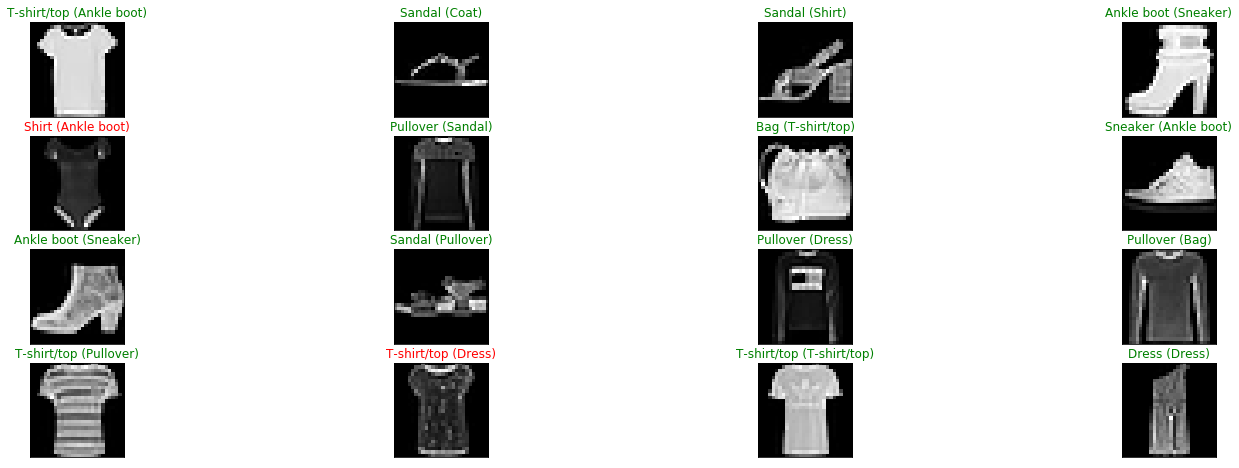

In [54]:
batch_size=16
test_loader2 = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)

# obtain one batch of test images
dataiter2 = iter(test_loader2)
images2, labels2 = dataiter2.next()
# get predictions
outputs = model(images2)
preds = np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy())
images2 = images2.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, batch_size/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images2[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels2[idx] else "red"))
fig

In [55]:
from sklearn.metrics import confusion_matrix

batch_size=10000
test_loader3 = torch.utils.data.DataLoader(dev_dataset, batch_size=10000, shuffle=True)
dataiter3 = iter(test_loader3)
images3, labels3 = dataiter3.next()
outputs = model(images3)
array  = confusion_matrix(labels3, np.squeeze(outputs.data.max(1, keepdim=True)[1].numpy()))

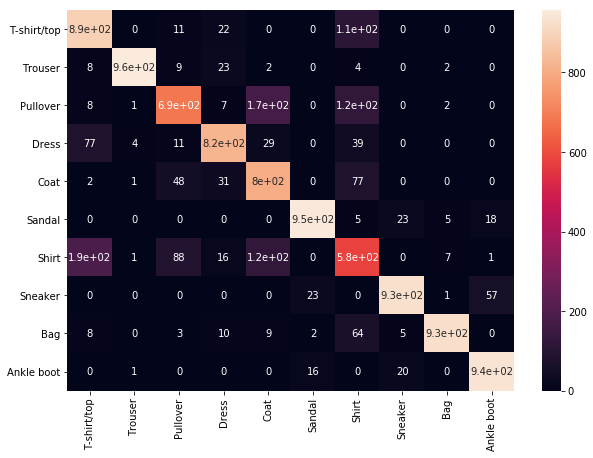

In [57]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes ])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# Explore different architectures and configurations

In [38]:
# Create nn.Module with different number of layers and sizes and 
# let's see who gets higher accuracy :)

## your code goes here

# Optimizers, Gradients and BackPropagation

When a neural network is trained, we need to compute gradients of the loss function, with respect to every weight and bias, and then update these weights using gradient descent.

With neural networks hitting billions of weights, doing the above step efficiently can make or break the feasibility of training.

## Drivatives: How autograd works

$$x_1 = \left[\begin{array}{l}
x_1^1\\
x_1^2
\end{array}\right]=
\left[\begin{array}{l}
0.1\\
0.2 
\end{array}\right]
$$

$$ x_2 = \left[\begin{array}{l}
x_2^1\\
x_2^2
\end{array}\right]=
\left[\begin{array}{l}
0.1\\
0.1 
\end{array}\right]
$$

$$y = 3\cdot x_1 + x_2 +  
\left[\begin{array}{l}
    1\\
    1
\end{array}\right] = 
\left[\begin{array}{l}
    3x_1^1 + x_1^1 + 1\\
    3x_1^2 + x_2^2 + 1
\end{array}\right]$$

$$f(x_1, x_2) = \textrm{mean}(y) = \frac{1}{2}(3x_1^1 + x_1^1 + 1 + 3x_1^2 + x_2^2 + 1)$$

$$(\nabla f)_{x_1} = \left[\begin{array}{l}
    \frac{\partial f}{\partial x_1^1}\\
    \frac{\partial f}{\partial x_1^2}
\end{array}\right] = 
\left[\begin{array}{l}
    1.5\\
    1.5
\end{array}\right] 
$$

### Now in pytorch


In [263]:
x1 = torch.tensor([0.1, 0.2], requires_grad=True)
x2 = torch.tensor([0.1, 0.1], requires_grad=True)
y = 3 * x1 + x2 + 1
y

tensor([1.4000, 1.7000], grad_fn=<AddBackward0>)

In [264]:
output = y.mean()

output.backward()
print(x1.grad, x2.grad)

tensor([1.5000, 1.5000]) tensor([0.5000, 0.5000])


The method `backward` calculates gradients. __It does not put them to zero!__ But there is a convinient method for that.

In [ ]:
y = 3 * x1 + x2 + 1
output = y.mean()
output.backward()
print(x1.grad, x2.grad)

## Let's check if more complicated derivatives are calculated correctly

We start with $x = 2$.

$y = f(x) = x^2 - 3$, $f(2) = 2^2 - 3 = 1$.

$z = g(y) = y^3 - 2y$, $g(f(2)) = g(1) = 1^3 - 2\cdot 1 = -1$

In [266]:
x = torch.tensor([2.0], requires_grad=True)
print("x = ", x)
y = x**2 - 3
print("y = ", y)
z = y**3 - 2*y
print("z = ", z)

x =  tensor([2.], requires_grad=True)
y =  tensor([1.], grad_fn=<SubBackward0>)
z =  tensor([-1.], grad_fn=<SubBackward0>)


#### Chain rule
$(g(f(x))' = g'(f(x))\cdot f'(x)$

#### Derivaties
$f'(x) = 2x$, $f'(2) = 2\cdot 2 = 4$

$g'(y) = 3y^2 - 2$, $g'(f(2)) = g'(1) = 3 - 2 = 1$

$(g(f(2))'=g'(f(2))\cdot f(2)) = 4 \cdot 1 = 4$

In [267]:
z.backward()
x.grad

tensor([4.])

### Variables, Tensors and Autograd

__Tensors:__ In simple words, its just an n-dimensional array in PyTorch.  They hold

- ```.data```: Value
- ```.grad```: This is basically the gradient computed up to this particular node, and the gradient of the every subsequent node, can be computed by multiplying the edge weight with the gradient computed at the node just before it.
- ```.grad_fn```: Stores the function ```Function``` to compute the gradient to be propagated.


On setting ```.requires_grad = True``` they start forming a backward graph that tracks every operation applied on them to calculate the gradients using something called a __dynamic computation graph (DCG)__. When you finish your computation you can call ```.backward()``` and have all the gradients computed automatically. The gradient for this tensor will be accumulated into ```.grad``` attribute.



Full description of how automatic differentiation works can be found here:
https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf

In [39]:
import torch
# Creating the graph
x = torch.tensor(1.0, requires_grad = True)
z = x ** 3
z.backward() #Computes the gradient 
print(x.grad.data) #Prints '3' which is dz/dx 

tensor(3.)


An important thing to notice is that when ```z.backward()``` is called, a tensor is automatically passed as ```z.backward(torch.tensor(1.0))```. The ```torch.tensor(1.0)``` is the external gradient provided to terminate the chain rule gradient multiplications. This external gradient is passed as the input to the ```MulBackward``` function to further calculate the gradient of x. The dimension of tensor passed into ```.backward()``` must be the same as the dimension of the tensor whose gradient is being calculated.

For example, if the gradient enabled tensor x and y are as below then, to calculate gradients of z (a 1x3 tensor) with respect to x or y , an external gradient needs to be passed to ```z.backward()``` function as follows: 

In [40]:
x = torch.tensor([0.0, 2.0, 8.0], requires_grad = True)
y = torch.tensor([5.0 , 1.0 , 7.0], requires_grad = True)
z = x * y
#z.backward()
z.backward(torch.FloatTensor([1.0, 1.0, 1.0]))
print(x.grad)
print(y.grad)

tensor([5., 1., 7.])
tensor([0., 2., 8.])



```Tensor``` and ```Function``` are interconnected and build up an acyclic graph, that encodes a complete history of computation. Each tensor has a ```.grad_fn``` attribute that references a ```Function``` that has created the Tensor (except for Tensors created by the user - their ```grad_fn``` is None).

In [41]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [42]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [43]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


You can also stop autograd from tracking history on Tensors with .requires_grad=True by wrapping the code block in with torch.no_grad():

In [44]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


#### Tensors implementation

In [45]:
# -*- coding: utf-8 -*-

import torch

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 28277924.0
1 22907764.0
2 19721316.0
3 16300856.0
4 12561182.0
5 8914264.0
6 6019518.5
7 3961192.5
8 2636403.75
9 1806958.0
10 1293552.0
11 967763.125
12 754330.9375
13 607824.125
14 502418.46875
15 423282.71875
16 361757.0
17 312439.78125
18 272015.90625
19 238309.46875
20 209852.390625
21 185605.5625
22 164764.90625
23 146747.40625
24 131092.796875
25 117426.2890625
26 105446.7421875
27 94910.171875
28 85623.046875
29 77409.53125
30 70121.5078125
31 63636.1171875
32 57864.18359375
33 52709.14453125
34 48095.13671875
35 43952.078125
36 40223.82421875
37 36863.5703125
38 33828.671875
39 31085.068359375
40 28603.2421875
41 26351.08984375
42 24304.302734375
43 22441.33984375
44 20744.86328125
45 19196.673828125
46 17782.466796875
47 16487.771484375
48 15301.1220703125
49 14213.291015625
50 13214.7607421875
51 12297.1328125
52 11452.9951171875
53 10675.646484375
54 9958.96484375
55 9297.9033203125
56 8687.3125
57 8123.45654296875
58 7602.34521484375
59 7119.791015625
60 6672.6494140625


420 0.010259219445288181
421 0.009934989735484123
422 0.009614624083042145
423 0.009308560751378536
424 0.009015943855047226
425 0.008732452057301998
426 0.008454235270619392
427 0.008187923580408096
428 0.007934261113405228
429 0.007681408431380987
430 0.0074420166201889515
431 0.007212712895125151
432 0.006985034327954054
433 0.006767674349248409
434 0.006558387540280819
435 0.006354662589728832
436 0.0061572459526360035
437 0.005967701319605112
438 0.00578670110553503
439 0.005610120482742786
440 0.005435529164969921
441 0.0052682021632790565
442 0.00511082774028182
443 0.004954702686518431
444 0.004804898984730244
445 0.004658098798245192
446 0.004516335669904947
447 0.004384092520922422
448 0.0042471131309866905
449 0.004125281237065792
450 0.004000548738986254
451 0.0038826509844511747
452 0.003767907852306962
453 0.003657427616417408
454 0.0035503332037478685
455 0.0034466153010725975
456 0.0033442643471062183
457 0.0032492540776729584
458 0.0031539169140160084
459 0.00306450133

#### Autorgrad

In [46]:
# -*- coding: utf-8 -*-
import torch

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the a scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()
     

0 32122034.0
1 25033652.0
2 23215288.0
3 22391756.0
4 20497532.0
5 16809490.0
6 12232495.0
7 8052637.0
8 5015081.0
9 3100795.0
10 1978567.75
11 1334713.25
12 957201.0625
13 725699.4375
14 574935.9375
15 470401.46875
16 393747.84375
17 334910.0625
18 288208.3125
19 250111.84375
20 218567.203125
21 192009.65625
22 169416.609375
23 150046.4375
24 133333.546875
25 118831.1015625
26 106185.25
27 95117.1328125
28 85392.7578125
29 76825.3671875
30 69259.84375
31 62560.2890625
32 56608.41015625
33 51306.640625
34 46574.7109375
35 42339.56640625
36 38544.875
37 35136.703125
38 32067.72265625
39 29302.123046875
40 26806.822265625
41 24551.435546875
42 22509.43359375
43 20657.06640625
44 18974.9921875
45 17447.763671875
46 16056.228515625
47 14788.142578125
48 13631.50390625
49 12575.4482421875
50 11609.8095703125
51 10725.8818359375
52 9916.990234375
53 9177.0322265625
54 8497.4755859375
55 7873.20458984375
56 7299.16845703125
57 6770.685546875
58 6284.02978515625
59 5835.53662109375
60 5421.685

466 6.644211680395529e-05
467 6.53346287435852e-05
468 6.471436063293368e-05
469 6.344247958622873e-05
470 6.248292629607022e-05
471 6.15837489021942e-05
472 6.0811526054749265e-05
473 6.0051828768337145e-05
474 5.882910409127362e-05
475 5.816843986394815e-05
476 5.7353146985406056e-05
477 5.6985256378538907e-05
478 5.580097058555111e-05
479 5.5068077926989645e-05
480 5.433475598692894e-05
481 5.3649444453185424e-05
482 5.29352473677136e-05
483 5.229185990174301e-05
484 5.157293344382197e-05
485 5.080763003206812e-05
486 5.002540274290368e-05
487 4.974133480573073e-05
488 4.903637454845011e-05
489 4.825352880288847e-05
490 4.784472912433557e-05
491 4.710541179520078e-05
492 4.661064667743631e-05
493 4.598150189849548e-05
494 4.5298642362467945e-05
495 4.485847966861911e-05
496 4.402825652505271e-05
497 4.355261262389831e-05
498 4.30532090831548e-05
499 4.2459098040126264e-05


#### Pytorch nn

In [47]:
# -*- coding: utf-8 -*-
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 666.0144653320312
1 610.4139404296875
2 563.7478637695312
3 523.6405639648438
4 488.08258056640625
5 456.7151794433594
6 428.6813659667969
7 403.0570068359375
8 379.4811096191406
9 357.733154296875
10 337.4783630371094
11 318.65911865234375
12 300.954833984375
13 284.3744201660156
14 268.7586669921875
15 254.02725219726562
16 240.10174560546875
17 226.83741760253906
18 214.17745971679688
19 202.1309814453125
20 190.66871643066406
21 179.77749633789062
22 169.40113830566406
23 159.5635223388672
24 150.2432403564453
25 141.3898468017578
26 132.98776245117188
27 125.03109741210938
28 117.48689270019531
29 110.35408020019531
30 103.59841918945312
31 97.21548461914062
32 91.1866683959961
33 85.50502014160156
34 80.16812133789062
35 75.13800811767578
36 70.40631866455078
37 65.96446228027344
38 61.79242706298828
39 57.87435531616211
40 54.19807815551758
41 50.75489807128906
42 47.52964782714844
43 44.50650405883789
44 41.682029724121094
45 39.04439163208008
46 36.579254150390625
47 34.2745

346 0.00016949452401604503
347 0.0001640053087612614
348 0.0001586922735441476
349 0.00015355485084000975
350 0.0001485860557295382
351 0.00014378162450157106
352 0.00013913490693084896
353 0.0001346336503047496
354 0.0001302833406953141
355 0.0001260749122593552
356 0.00012200209312140942
357 0.0001180644758278504
358 0.00011425303819123656
359 0.00011056229413952678
360 0.00010700067650759593
361 0.00010354518599342555
362 0.00010021160414908081
363 9.698310896055773e-05
364 9.385889279656112e-05
365 9.083197073778138e-05
366 8.791188156465068e-05
367 8.508058817824349e-05
368 8.234034612542018e-05
369 7.969498983584344e-05
370 7.712869410170242e-05
371 7.464974623871967e-05
372 7.22497352398932e-05
373 6.992902490310371e-05
374 6.768177991034463e-05
375 6.551806291099638e-05
376 6.340655090752989e-05
377 6.137863238109276e-05
378 5.940664414083585e-05
379 5.7506091252435e-05
380 5.5662967497482896e-05
381 5.387696728575975e-05
382 5.2154540753690526e-05
383 5.048528328188695e-05
384

Up to this point we have updated the weights of our models by manually mutating the Tensors holding learnable parameters (with ```torch.no_grad()``` or ```.data``` to avoid tracking history in autograd). This is not a huge burden for simple optimization algorithms like stochastic gradient descent, but in practice we often train neural networks using more sophisticated optimizers like AdaGrad, RMSProp, Adam, etc.



In [48]:
# -*- coding: utf-8 -*-
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 736.442626953125
1 718.6072998046875
2 701.3286743164062
3 684.6860961914062
4 668.489501953125
5 652.6783447265625
6 637.3101806640625
7 622.5323486328125
8 608.1959838867188
9 594.2584228515625
10 580.729736328125
11 567.5486450195312
12 554.7413940429688
13 542.34130859375
14 530.2955932617188
15 518.6387329101562
16 507.2729797363281
17 496.1631774902344
18 485.3522644042969
19 474.8202819824219
20 464.54150390625
21 454.579345703125
22 444.9238586425781
23 435.49822998046875
24 426.2279968261719
25 417.1338806152344
26 408.23858642578125
27 399.5425720214844
28 391.0209045410156
29 382.7369689941406
30 374.6372985839844
31 366.70074462890625
32 358.97821044921875
33 351.4059753417969
34 344.00439453125
35 336.7708740234375
36 329.67840576171875
37 322.7195739746094
38 315.9037780761719
39 309.20599365234375
40 302.6106262207031
41 296.1268005371094
42 289.779052734375
43 283.5263366699219
44 277.381591796875
45 271.3527526855469
46 265.4395751953125
47 259.64337158203125
48 253.

369 0.002814996987581253
370 0.002706975908949971
371 0.002602917840704322
372 0.002502846298739314
373 0.0024065591860562563
374 0.0023138057440519333
375 0.0022245447617024183
376 0.0021385857835412025
377 0.0020558403339236975
378 0.0019762113224714994
379 0.0018995787249878049
380 0.001825792365707457
381 0.0017547915922477841
382 0.001686458708718419
383 0.0016206874279305339
384 0.0015574222197756171
385 0.0014965190785005689
386 0.0014379465719684958
387 0.001381576876156032
388 0.0013273406075313687
389 0.0012751680333167315
390 0.0012249869760125875
391 0.0011767178075388074
392 0.00113027507904917
393 0.0010856078006327152
394 0.001042657531797886
395 0.001001353608444333
396 0.0009616099414415658
397 0.0009234091849066317
398 0.0008866711868904531
399 0.0008513594511896372
400 0.0008174233371391892
401 0.000784758769441396
402 0.0007533728494308889
403 0.0007232003845274448
404 0.0006942044128663838
405 0.0006663164240308106
406 0.0006395486416295171
407 0.000613786512985825

### The optimizer in detail

In [49]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, D_out = 64, 1, 1

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

In [50]:
# Let's define a simple predefined linear model (no activation funcion)
model = nn.Linear(in_features=1, out_features=1, bias=True)

At the beginning the values are random 

In [51]:
model.weight, model.bias

(Parameter containing:
 tensor([[-0.7088]], requires_grad=True), Parameter containing:
 tensor([-0.8800], requires_grad=True))

Now let's choose the loss fuction and the optimizer. We will choose mean square error for the loss and SGD as optimizer

In [52]:
### Choose loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

Let's update the weights

In [53]:
# Zero gradients (just in case)
optimizer.zero_grad()

# Forward pass, calculate predictions
y_train_hat = model(x)

In [54]:
loss = loss_function(y_train_hat, y)

#### Weights before

In [55]:
model.weight, model.bias

#### Weights after

In [56]:
## Backward propagation
loss.backward()
model.weight, model.bias

(Parameter containing:
 tensor([[-0.7088]], requires_grad=True), Parameter containing:
 tensor([-0.8800], requires_grad=True))

In [57]:
## Upade weights
optimizer.step()
model.weight, model.bias

(Parameter containing:
 tensor([[-0.6088]], requires_grad=True), Parameter containing:
 tensor([-0.7800], requires_grad=True))

In [57]:
# EXERCISE 1
#### Check the value of the gradient hold in the weigth and bias tensors at each stem

### Your code here

In [58]:
# Exercise 2
# Train the model LinearNN() and your custom one using 4 different optimizers and compare the evolution of
# the loss over the iterations of the training procedure. you can reuse the model definition as well as the
# training function, which outputs the training loss at the different time steps.
# Look for the effect of the learnign rate

Epoch: 1, Batch: 1000, Avg. Loss: 0.6688350162804126
Epoch: 1, Batch: 2000, Avg. Loss: 0.5257477377727627
Epoch: 1, Batch: 3000, Avg. Loss: 0.5236351222917438
Epoch: 2, Batch: 1000, Avg. Loss: 0.4810239999294281
Epoch: 2, Batch: 2000, Avg. Loss: 0.4841047325208783
Epoch: 2, Batch: 3000, Avg. Loss: 0.4730063216909766
Finished Training


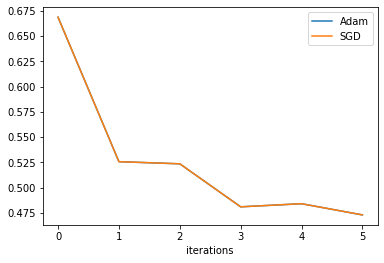

In [64]:
# This code can help you generate a starting image
plt.figure
plt.plot(training_loss_adam, label='Adam')
plt.plot(training_loss_sgd,label='SGD')
plt.legend()
plt.xlabel('loss')
plt.xlabel('iterations')
plt.show()

# Keeping Track of Trainning with Tensorboard
Next, we implement a MNIST classifier using a simple neural network and visualize the training process using TensorBoard. In training phase, we plot the loss and accuracy functions through scalar_summary. In addition, we visualize the weight and gradient values of the parameters of the neural network using histogram_summary. PyTorch code for handling these summary functions can be found here.

In [ ]:
! pip install tensorflow
! pip install scipy
! pip install pillow

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from logger import Logger

### Load dataset and DataLoader
# Fashion MNIST dataset 
## Your code here

# Data loader
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Fully connected neural network model
model = LinearNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  

In [ ]:
logger = Logger('./logs')

In [ ]:

data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 50000

# Start training
for step in range(total_step):
    
    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch images and labels
    images, labels = next(data_iter)
    images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    _, argmax = torch.max(outputs, 1)
    accuracy = (labels == argmax.squeeze()).float().mean()

    if (step+1) % 500 == 0:
        print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}' 
               .format(step+1, total_step, loss.item(), accuracy.item()))
    if (step+1) % 100 == 0:
       # print ('Step [{}/{}], Loss: {:.4f}, Acc: {:.2f}' 
       #        .format(step+1, total_step, loss.item(), accuracy.item()))

        # ================================================================== #
        #                        Tensorboard Logging                         #
        # ================================================================== #

        # 1. Log scalar values (scalar summary)
        info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

        for tag, value in info.items():
            logger.scalar_summary(tag, value, step+1)

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in model.named_parameters():
            tag = tag.replace('.', '/')
            logger.histo_summary(tag, value.data.cpu().numpy(), step+1)
            logger.histo_summary(tag+'/grad', value.grad.data.cpu().numpy(), step+1)


To run the TensorBoard, open a new terminal and run the command below. Then, open http://localhost:6006/ on your web browser.

```$ tensorboard --logdir='./logs' --port=6006```

In [ ]:
! tensorboard --logdir='./logs' --port=6006

# Regularization

 The following abstract class implements a generic regularizer.

In [58]:
class _Regularizer(object):
    """
    Parent class of Regularizers
    """
    def __init__(self, model):
        super().__init__()
        self.model = model

    def regularized_param(self, param_weights, reg_loss_function):
        raise NotImplementedError

    def regularized_all_param(self, reg_loss_function):
        raise NotImplementedError

L1 Regularizer can be implemented as follows

In [87]:
class L1Regularizer(_Regularizer):
    """
    L1 regularized loss
    """
    def __init__(self, model, lambda_reg=0):
        super().__init__(model=model)
        self.lambda_reg = lambda_reg

    def regularized_param(self, param_weights, reg_loss_function):
        reg_loss_function += self.lambda_reg * self.__add_l1(var=param_weights)
        return reg_loss_function

    def regularized_all_param(self, reg_loss_function):
        for model_param_name, model_param_value in self.model.named_parameters():
            if model_param_name.endswith('weight'):
                reg_loss_function += self.lambda_reg * self.__add_l1(var=model_param_value)
        return reg_loss_function

    @staticmethod
    def __add_l1(var):
        return var.abs().sum()

The regularizer adds the regularization to the loss function.

In [88]:
reg_loss = L1Regularizer(model).regularized_all_param(loss)

Let's train the network 

In [112]:
batch_size = 16
def train_reg(n_epochs):
    
    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            inputs, labels = data

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)
            reg_loss = L1Regularizer(model).regularized_all_param(loss)
            # backward pass to calculate the parameter gradients
            reg_loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += reg_loss.item()
            
            if batch_i % 1000 == 999:    # print every 1000 batches
                avg_loss = running_loss/1000
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [113]:
model = LinearNN()
n_epochs = 2 # start small to see if your model works, initially

model.train() # put model in train mode (important with, for example, dropouts, batch normalizations...)

training_loss = train_reg(n_epochs) # call train and record the loss over time

Epoch: 1, Batch: 1000, Avg. Loss: 2.298913866043091
Epoch: 1, Batch: 2000, Avg. Loss: 2.2995844464302064
Epoch: 1, Batch: 3000, Avg. Loss: 2.2986987011432647
Epoch: 2, Batch: 1000, Avg. Loss: 2.29794136929512
Epoch: 2, Batch: 2000, Avg. Loss: 2.3003218512535097
Epoch: 2, Batch: 3000, Avg. Loss: 2.2984714772701262
Finished Training


In [114]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
model.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data

    # forward pass to get outputs
    outputs = model(inputs)

    # calculate the loss
    loss = criterion(outputs, labels)
            
    # update average test loss 
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

Test Loss: 2.296969



In [115]:
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of T-shirt/top:  0% ( 5/1034)
Test Accuracy of Trouser: 48% (491/1005)
Test Accuracy of Pullover: 14% (144/1001)
Test Accuracy of Dress:  5% (54/979)
Test Accuracy of  Coat:  0% ( 0/959)
Test Accuracy of Sandal:  6% (67/1004)
Test Accuracy of Shirt: 11% (112/1007)
Test Accuracy of Sneaker: 20% (206/1009)
Test Accuracy of   Bag: 38% (399/1027)
Test Accuracy of Ankle boot:  0% ( 0/975)

Test Accuracy (Overall): 14% (1478/10000)


### L2 Regularizer and ElasticNet (L1 + L2)

In [ ]:
### Implement the L2 and Elastic Net regularization

In [ ]:
class L2Regularizer(_Regularizer):
    
    ### Implement the L2 regularizer

In [ ]:
class ElasticNetRegularizer(_Regularizer):

In [ ]:
## Implement a model with Dropout and train it.